In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
from numpy.fft import fftshift,ifft
from scipy.signal import stft, windows

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
dataset_path = 'G:/MRM_0.5/'

train_data_path = dataset_path + 'train/'
test_data_path = dataset_path + 'test/'

# Function of Load data

In [26]:
def load_pkl(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)
    
def rcs(echo):
    return 4*np.pi*np.abs(echo)**2

def awgn(signal, snr):
    
    # Calculate signal power and convert SNR to linear scale
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr / 10)
    
    # Calculate noise power and generate complex noise
    noise_power = signal_power / snr_linear
    noise_real = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise_imag = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise = noise_real + 1j * noise_imag
    
    # Add noise to the signal
    signal_with_noise = signal + noise
    
    return signal_with_noise
    
    
# def data processing here.

def preprocessing(data, snr = None):
    polar_type = 'HH'
    E = awgn(data['echo'][polar_type],snr=snr)
    data = rcs(E)
    data = (data-np.min(data))/(np.max(data)-np.min(data)) # 归一化
    
    # return (rcs(E), E, awgn(data['hrrp'][polar_type],snr=snr))
    return data



class Dataset(Dataset):
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir
        self.instance_list = self.get_instance()
    
    def get_instance(self):
        instance_list = []
        for label in os.listdir(self.dataset_dir):
            label_dir = os.path.join(self.dataset_dir,label)
            label_list = glob.glob(label_dir+'/*.pkl')
            instance_list += label_list
        return instance_list

    def __len__(self):
        return len(self.instance_list)

    def __getitem__(self, idx):
        data = load_pkl(self.instance_list[idx])
        x = preprocessing(data, snr = 20)
        y = data['target_id']
        return torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)
        # return x,y
    
train_dataset = Dataset(train_data_path)
test_dataset = Dataset(test_data_path)

In [29]:
x,y = train_dataset.__getitem__(0)
print('label is y')

label is y


(50.0, 150.0)

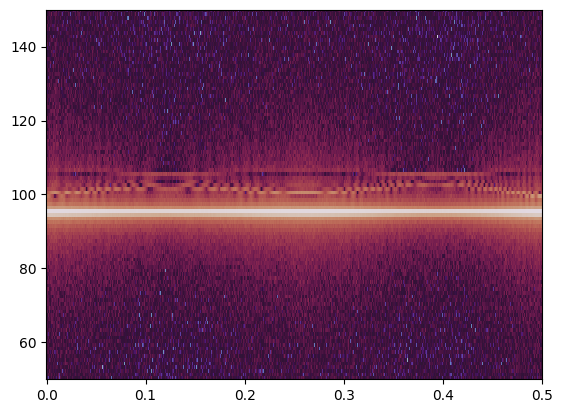

In [90]:
pad_size = None

if pad_size is None:
    pad_size = 201

def pad_hrrp(matrix, target_length):
    if target_length==201:
        return matrix
    else:
        rows, cols = matrix.shape 
        padded_matrix = np.zeros((target_length, cols),dtype=np.complex128)
        padded_matrix[:rows, :] = matrix
        return padded_matrix

hrrp = x[2]
hrrp = pad_hrrp(hrrp,pad_size)
hrrp = fftshift(ifft(hrrp,axis = 0),axes=0)
hrrp = np.log10(np.abs(hrrp))

plt.pcolormesh(np.linspace(0,0.5,512), np.linspace(0,201,pad_size), hrrp, cmap='twilight')
plt.ylim([50,150])

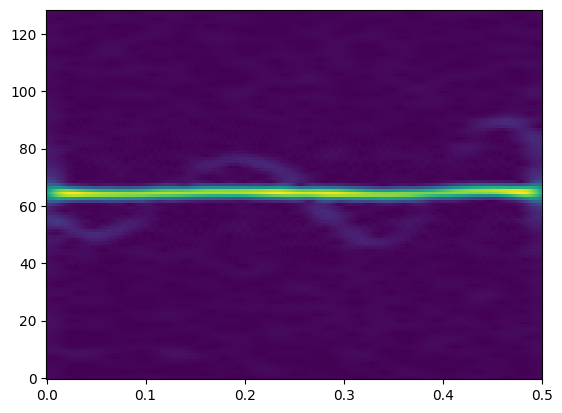

In [91]:
nfft = 128
def STFT(st,nfft):
    winlen = 64
    _, _, Zxx = stft(st, fs=1024, window = windows.hamming(winlen), nperseg=winlen, nfft=nfft ,noverlap=winlen-1, boundary='zeros', return_onesided=False)
    return np.fft.fftshift(Zxx,axes=0)

echo =  x[1]
Z = STFT(echo,nfft)
T = 0.5
t = np.linspace(0,0.5,512)
nfft = np.linspace(0,nfft,nfft)
# plt.imshow(np.abs(Z)[:,:-1],origin='lower',vmin=0, vmax=1e-2)
plt.pcolormesh(t, nfft, np.abs(Z)[:,:-1])

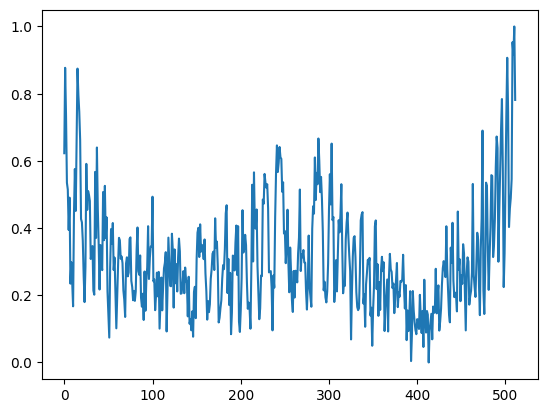

In [31]:
plt.plot((x.cpu()));

# Classification by Rocket(ONLY RCS)

In [46]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [45]:
dataset = []
datalabel = []
for data,label in tqdm(train_loader, desc='processing:'):
    dataset.append(data.cpu().numpy())
    datalabel.append(label.cpu().numpy())
    
train_data = np.array(dataset)
train_label = np.array(datalabel).reshape(-1)

processing:: 100%|██████████| 4000/4000 [00:10<00:00, 375.59it/s]


In [47]:
test_data = []
test_label = []

for data,label in tqdm(test_loader, desc='processing:'):
    test_data.append(data.cpu().numpy())
    test_label.append(label.cpu().numpy())
    
test_data = np.array(test_data)
test_label = np.array(test_label).reshape(-1)

processing:: 100%|██████████| 1600/1600 [00:04<00:00, 358.03it/s]


In [48]:
from aeon.classification.convolution_based import RocketClassifier
from sklearn.metrics import accuracy_score

rocket = RocketClassifier(num_kernels=1000, n_jobs=-1)
rocket.fit(train_data, train_label)
y_pred = rocket.predict(test_data)
print(accuracy_score(test_label, y_pred))

0.854375


# Classification by DL

In [50]:
class TimeSeriesClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(TimeSeriesClassificationModel, self).__init__()
        layers = []
        in_size = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_size, h_size))
            layers.append(nn.ReLU())
            in_size = h_size
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
# 参数设置
input_size = 512  # 时间序列长度
hidden_sizes = [256, 128, 64, 32]  # 隐藏层大小
output_size = 4  # 类别数

num_epochs = 200
learning_rate = 0.001


# 初始化模型、损失函数和优化器
model = TimeSeriesClassificationModel(input_size, hidden_sizes, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [51]:
def train(dataloader, loss_fn, optimizer):
    total_acc, total_count, total_loss, = 0, 0, 0
    model.train()
    for series, label in dataloader:
        predicted_label = model(series)
        loss = loss_fn(predicted_label, label)
        # Back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_acc += (predicted_label.argmax(1) == label).sum().item()  # predict true
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def test(dataloader, loss_fn):
    model.eval()
    total_acc, total_count, total_loss, = 0, 0, 0

    with torch.no_grad():
        for series, label in dataloader:
            
            predicted_label = model(series)
            loss = loss_fn(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def fit(epochs, train_dl, test_dl, loss_fn, optimizer):
    train_loss = [] 
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        
        epoch_loss, epoch_acc = train(train_dl, loss_fn, optimizer)
        epoch_test_loss, epoch_test_acc = test(test_dl, loss_fn)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                    "test_loss: {:.5f}, test_acc: {:.1f}%")
        if epoch%10 ==0:
            print(template.format(
                epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
    return train_loss, test_loss, train_acc, test_acc

In [53]:
EPOCHS = 100
train_loss, test_loss, train_acc, test_acc = fit(EPOCHS, train_loader, test_loader, criterion, optimizer)

KeyboardInterrupt: 